# Intent Detection through a Neural Network-Enabled Text Classifier

#### Contributors: Alexander Heger, Mugdha Khairnar, Ishan Nagrani

## 1. Introduction


### 1.1. Problem Statement

Our goal is to create a neural network text classifier which accurately predicts intent given a text document.  Here, our predictors are the unique text tokens of questions posted to Stack Overflow.  The labels are the Tags that Stack Overflow’s users assign to each question, since these indicate the intent of the question body.  We aim to identify the model which best predicts the true label for each post.

### 1.2. Motivation

We chose this prediction task to emulate the upstream stages of a language model-enabled chatbot. The model that we deliver will be able to predict labels which inform the response of a language model which could be used to answer questions about a product or topic in an online chat. Any company with an online presence could use our model, combined with a chatbot, to automate the purpose traditionally served by a call center. 

While our model is only a precursor to a fully functioning chatbot, the predictions it accurately generates will provide insights into the context of a user’s question.  Intent detection through neural networks is not a new idea; however, we have not seen our dataset used to this end, nor in the context of executing an upstream process for a chatbot.

### 1.3. Data 

Our data set comprises 139,638 questions posted to the programming forum, Stack Overflow from August 1 to August 31, 2022. We sourced our data through [Google BigQuery](https://console.cloud.google.com/marketplace/product/stack-exchange/stack-overflow/) which pulls from Stack Exchange’s Data Explorer tool.  Our data contains the body text of various users’ questions posted to Stack Overflow along with the labels (Tags) attributed to each question by the site’s users, along with 18 other columns of metadate (e.g., ID, creation date, number of viewers, etc.). 

At various points through the notebook we'll sample smaller sets of the data in order to make processes more efficient given Colab's resource limitations.  We chose to use Google Colab Pro+ after finding that VertexAI's Jupyter Notebook version was incompatible with natural language processing (NLP) packages key to our analysis. 

## 2. Data Pre-processing

### 2.1. Read Data

As with any machine learning task in Python, we begin by importing a number of packages necessary to our analysis.  Those of note are TensorFlow and Keras since we aim to use deep learning to make single label predictions in a multiclass space.

In [ ]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from collections import Counter
import re
import spacy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import text_to_word_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR) # Suppresses tf warnings during training

We downloaded our data from Google Cloud Platform's BigQuery service, and stored it in a Shared Drive across all members of this project.

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')
data_folder = '/content/drive/Shareddrives/BA865_Group_Project/data/'

Mounted at /content/drive


In [ ]:
# Read data from Shared Drive
data = pd.read_csv(data_folder + 'aug2022_stackoverflow.csv')

# Overview of data shape, null values, preview
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139638 entries, 0 to 139637
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        139638 non-null  int64  
 1   title                     139638 non-null  object 
 2   body                      139638 non-null  object 
 3   accepted_answer_id        41278 non-null   float64
 4   answer_count              139638 non-null  int64  
 5   comment_count             139638 non-null  int64  
 6   community_owned_date      0 non-null       float64
 7   creation_date             139638 non-null  object 
 8   favorite_count            8157 non-null    float64
 9   last_activity_date        139638 non-null  object 
 10  last_edit_date            64703 non-null   object 
 11  last_editor_display_name  231 non-null     object 
 12  last_editor_user_id       64472 non-null   float64
 13  owner_display_name        612 non-null     o

,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,73210679,az acr login raises DOCKER_COMMAND_ERROR with ...,<p>Windows 11 with wsl2 ubuntu-22.04.</p>\n<p>...,73247188.0,1,0,NaN,2022-08-02 16:16:31.81 UTC,NaN,2022-08-05 09:00:14.693 UTC,2022-08-02 16:32:13.7 UTC,NaN,11226740.0,NaN,11226740.0,NaN,1,0,azure-container-registry|docker-daemon,256
1,73284406,Run Azure log query from the command line with...,<p>I am trying to get the Azure log query data...,NaN,2,0,NaN,2022-08-08 21:53:16.703 UTC,NaN,2022-08-10 04:49:20.527 UTC,2022-08-09 08:12:13.92 UTC,NaN,2395282.0,NaN,19123691.0,NaN,1,0,azure|azure-devops|azure-application-insights|...,256
2,73250763,Error CS0246: The type or namespace name 'Stre...,<p>I have these errors when trying to write th...,73251390.0,1,0,NaN,2022-08-05 13:43:25.85 UTC,NaN,2022-08-05 16:40:00.61 UTC,2022-08-05 16:40:00.61 UTC,NaN,17654458.0,NaN,17654458.0,NaN,1,3,c#|unity3d,512
3,73406942,Google workspace account has been suspended wi...,<p>Many years ago I set up my domain so Google...,73419827.0,1,0,NaN,2022-08-18 17:05:12.95 UTC,NaN,2022-08-19 16:43:13.243 UTC,2022-08-19 16:43:13.243 UTC,NaN,897007.0,NaN,897007.0,NaN,1,0,google-workspace,512
4,73200968,Mac Unity package manager error resolving pack...,"<p>I use unity 2021.3.7f1, I was creating a ne...",NaN,1,0,NaN,2022-08-02 01:00:36.2 UTC,NaN,2022-08-17 00:40:54.303 UTC,NaN,NaN,NaN,NaN,19502695.0,NaN,1,0,unity3d,257


In [ ]:
data.isnull().sum()

id                               0
title                            0
body                             0
accepted_answer_id           98360
answer_count                     0
comment_count                    0
community_owned_date        139638
creation_date                    0
favorite_count              131481
last_activity_date               0
last_edit_date               74935
last_editor_display_name    139407
last_editor_user_id          75166
owner_display_name          139026
owner_user_id                  585
parent_id                   139638
post_type_id                     0
score                            0
tags                             0
view_count                       0
dtype: int64

### 2.2. Clean and Organize Labels

Next, we turn our attention to the labels (`tags`) that will be the target of our prediction.  In the original data set, these are stored as string records with individual tags separated by the '|' character.  We first narrow down the data to only the columns we'll use for our analysis, and take a `50,000` record sample of the data to make computation more manageable.  We then split `tags` in order to find each record's most prominent label.

In [ ]:
keep_cols = ['title', 'body', 'tags']

# Drop unused columns
data = data.drop(columns=set(data.columns) - set(keep_cols))
data.head()

,title,body,tags
0,az acr login raises DOCKER_COMMAND_ERROR with ...,<p>Windows 11 with wsl2 ubuntu-22.04.</p>\n<p>...,azure-container-registry|docker-daemon
1,Run Azure log query from the command line with...,<p>I am trying to get the Azure log query data...,azure|azure-devops|azure-application-insights|...
2,Error CS0246: The type or namespace name 'Stre...,<p>I have these errors when trying to write th...,c#|unity3d
3,Google workspace account has been suspended wi...,<p>Many years ago I set up my domain so Google...,google-workspace
4,Mac Unity package manager error resolving pack...,"<p>I use unity 2021.3.7f1, I was creating a ne...",unity3d


In [ ]:
# Take a 50,000 record random sample 
df = data.sample(50000, random_state=42)
df = df.reset_index(drop=True)
len(df)

50000

In [ ]:
# Split tags
all_tags = []
for tags in df['tags']:
    tag_list = tags.split('|')
    all_tags.extend(tag_list)

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

# Display the top 10 most occurring tags
top_n_tags = 10
most_common_tags = tag_counts.most_common(top_n_tags)
print(most_common_tags)

[('python', 7854), ('javascript', 5467), ('reactjs', 2960), ('java', 2338), ('c#', 2200), ('html', 1927), ('android', 1712), ('node.js', 1655), ('flutter', 1525), ('r', 1461)]


In [ ]:
len(set(all_tags))

14389

We elect to keep only those records with the `10` most frequent labels in `tags`.  This makes our problem more feasible since in our `50,000` record sample, there are `14,389` distinct `tags`.

In [ ]:
# Find the most popular tag for each record, relative to the whole data set
def most_common_tag(tags, tag_counts):
    tag_list = tags.split('|')
    tag_freqs = [(tag, tag_counts[tag]) for tag in tag_list]
    most_common = max(tag_freqs, key=lambda x: x[1])
    return most_common[0]

# Extract individual tags
all_tags = []
for tags in df['tags']:
    tag_list = tags.split('|')
    all_tags.extend(tag_list)

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

# Find the most frequent tag for each row
df['most_common_tag'] = df['tags'].apply(lambda tags: most_common_tag(tags, 
                                                                      tag_counts))

print(df[['tags', 'most_common_tag']])

                                                    tags      most_common_tag
0                python|loops|web-scraping|beautifulsoup               python
1                                laravel|terminal|routes              laravel
2                                              mysql|sql                  sql
3                javascript|class|constructor|apply|call           javascript
4                                         prism|prismlib                prism
...                                                  ...                  ...
49995                          java|netbeans|netbeans-12                 java
49996              amazon-web-services|amazon-s3|aws-cli  amazon-web-services
49997                                sql|google-bigquery                  sql
49998  java|spring|database|health-check|spring-actuator                 java
49999                                          vba|forms                  vba

[50000 rows x 2 columns]


In [ ]:
# Count records for each most_common_tag
df['most_common_tag'].value_counts().head(10)

python        7854
javascript    5417
java          2293
c#            2153
reactjs       1728
r             1422
flutter       1356
android       1313
php           1130
c++           1113
Name: most_common_tag, dtype: int64

In [ ]:
# Count unique tags
df['most_common_tag'].nunique()

2355

The preparation of our labels which looks at only the 10 most common `tags` leaves at least `1,113` records for our least common label, "c++".  Within this subset of data, there still exists `2,355` distinct tags, which indicates the diversity of posts still present in our sample.  When we limit our data to only those with one of the most common `tags`, we are left with `25,779` records.

In [ ]:
top10 = list(df['most_common_tag'].value_counts().head(10).index.values)
df_top10 = df[df['most_common_tag'].isin(top10)]
df_top10 = df_top10.reset_index(drop=True)
df_top10.count()

title              25779
body               25779
tags               25779
most_common_tag    25779
dtype: int64

## 3. Model Development

For each of the models we'll develop, some parameters will stay the same.  These are `adam` as the optimizer, `categorical_crossentropy` as the loss function, and `categorical_accuracy` as a tracked metric.  We selected `adam` as an optimizer because it was purpose-built for deep learning and improves upon stochastic gradient descent in terms of performance without overfitting.

`categorical_crossentropy` is an intuitive loss function for our prediction problem, since it works with one-hot encoded labels in a multiclass space. Finally, we choose `categorical_accuracy` as a metric for its interpretability with regard to our labels.

### 3.1. Dense, Feed-forward Neural Network

#### 3.1.1. Cleaning Text for Dense Neural Network

The first model we attempt is a dense neural network.  For this relatively simple model, perform the following preprocessing steps:

1. Merge `title` and `body` in order to make a combined `text` feature, our corpus.

2. Remove symbols and extra spaces from `text`.

3. Remove stopwords found in spaCy's English stopword dictionary. Stopwords are commonly used prepositions and pronouns that convey little substantive meaning in language.

4. Identify and count all unique terms used in our body of `text`.

5. Remove all but the `10,000` most frequently used terms, or tokens, in the corpus.

6. Index and one-hot encode each record (document) for its present tokens.

This process, a unigram approach to learning each document, makes the presence of each individual token a predictor in our classification problem.

In [ ]:
# Define text cleaning function
def clean_text(text):
    text = re.sub(r'[^\w ]', ' ', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.strip()  # Remove leading and trailing spaces
    return text

# Combine the Title and Body
df_top10['text'] = df_top10['title'] + ' ' + df_top10['body']
df_top10['text'] = df_top10['text'].apply(clean_text)

In [ ]:
df_top10['text']

0        how to iterate through a list of URL and save ...
1        Why use constructor at all p I came across the...
2        How to instantiate different subclasses by str...
3        data gets repeated when input to text file p i...
4        How to create a dynamic GraphQL query using va...
                               ...                        
25774    R Automatically Forcing Titles To Become Horiz...
25775    How to use GL_TEXTURE_2D_ARRAY with stb_image ...
25776    Finding elements by Class returning blank list...
25777    repeat number sequence on java p So recently a...
25778    Change HealthIndicator s status based on anoth...
Name: text, Length: 25779, dtype: object

In [ ]:
# Strip punctuation, odd characters, and make things lower-case
text = []
for i in range(len(df_top10)):
  text.append(text_to_word_sequence(df_top10['text'][i], 
                                    filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n0123456789'))

In [ ]:
print(f"Without removing stopwords, the first entry in text has {len(text[0])} words.")

Without removing stopwords, the first entry in text has 346 words.


In [ ]:
# Load the spaCy English language model
nlp = spacy.load('en_core_web_sm')

# Define a set of stopwords
stopwords = set(spacy.lang.en.stop_words.STOP_WORDS)

# Remove stopwords from text
terms = [[word for word in post if word not in stopwords] for post in text]

# Check fewer words in terms
print(f"Without stopwords, the first entry in terms has {len(terms[0])} words.")

# Count the occurrences of each word in text
word_counts = Counter(word for post in terms for word in post)

# Sort word_counts
sorted_set = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# Create unique_terms dictionary from sorted_set
unique_terms = dict(sorted_set)

# Create a dictionary containing only the 10,000 most frequent words
frequent_terms = dict(sorted_set[:10000])

# Remove infrequent words from text
filtered_terms = [list(set([word for word in sublist if word in frequent_terms])) for sublist in terms]

Without stopwords, the first entry in terms has 294 words.


In [ ]:
# Generae an index for each term to be used in the one-hot matrix
word_index = {term: i for i, term in enumerate(frequent_terms)}

In [ ]:
# Define a function to assign values to our one-hot matrix
def vectorize_posts(posts, dimension=len(frequent_terms)): 
    # Make our blank matrix of 0's to store hot encodings.
    results = np.zeros((len(posts), dimension))

    # For each observation and element in that observation,
    # Update the blank matrix to a 1 at row obs, column element value.
    for i, term in enumerate(posts):
        for j in term:
            results[i, word_index[j]] = 1
    return results

# One-hot encode top 10,000 tokens, our predictors
text_onehot = vectorize_posts(filtered_terms)
predictors = text_onehot
predictors.shape

(25779, 10000)

In [ ]:
text_onehot[:5]

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.]])

#### 3.1.2. One-Hot Encoding Labels

We also one-hot encode the top `10` tags, our labels in this problem, to follow the same structure as our predictors and because there is no ordinal relationship between `tags`.

In [ ]:
labels = df_top10["most_common_tag"]

In [ ]:
labels.shape

(25779,)

In [ ]:
# Convert labels to integer values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
labels_onehot = keras.utils.to_categorical(encoded_labels)
print(labels_onehot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### 3.1.3. Train-Test Split

We segment our data into training and testing sets to measure how accurately our model can predict the label associated with each question.

In [ ]:
# Split the data using encoded_labels
train_data, test_data, train_labels, test_labels = train_test_split(
  predictors, labels_onehot, test_size=0.2, random_state=42
)

#### 3.1.4. Model Training

Here we train our dense neural network on `80`% of the original `25,779` documents attributable to the top `10` tags. We keep `20`% of the training set as a validation set, in order to estimate the model's label predictions of unseen documents.  

The model begins with a Dropout layer which randomly sets `50`% of inputs to `0` which helps prevent overfitting during training.  This layer is followed by `3` Dense layers with decreasing units, each executing `output = activation(dot(input, kernel) + bias)`.  The first `2` Dense layers use rectified linear unit (relu) activations, and the final Dense layer processes `10` units, the possible labels for each document, and uses the softmax activation function to output a single label prediction.

In [ ]:
# Dense network
def build_model():
    model = keras.Sequential([
        layers.Dropout(0.5),
        layers.Dense(750, activation="relu", kernel_regularizer="l2"),
        layers.Dense(50, activation="relu", kernel_regularizer="l2"),
        layers.Dense(10, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    return model

model = build_model()

In [ ]:
# Train dense network and keep best version
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="DenseNet.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(train_data, train_labels, validation_split=0.2, epochs=20, batch_size=25, callbacks=callbacks)

Epoch 1/20
660/660 [==============================] - 5s 6ms/step - loss: 2.1723 - categorical_accuracy: 0.6484 - val_loss: 1.5308 - val_categorical_accuracy: 0.7741
Epoch 2/20
660/660 [==============================] - 3s 5ms/step - loss: 1.7322 - categorical_accuracy: 0.6841 - val_loss: 1.4374 - val_categorical_accuracy: 0.7947
Epoch 3/20
660/660 [==============================] - 3s 5ms/step - loss: 1.5573 - categorical_accuracy: 0.7091 - val_loss: 1.2767 - val_categorical_accuracy: 0.7949
Epoch 4/20
660/660 [==============================] - 3s 5ms/step - loss: 1.4368 - categorical_accuracy: 0.7143 - val_loss: 1.1601 - val_categorical_accuracy: 0.7971
Epoch 5/20
660/660 [==============================] - 3s 5ms/step - loss: 1.3258 - categorical_accuracy: 0.7341 - val_loss: 1.0971 - val_categorical_accuracy: 0.8133
Epoch 6/20
660/660 [==============================] - 3s 5ms/step - loss: 1.2462 - categorical_accuracy: 0.7408 - val_loss: 1.0338 - val_categorical_accuracy: 0.8276
Epoc

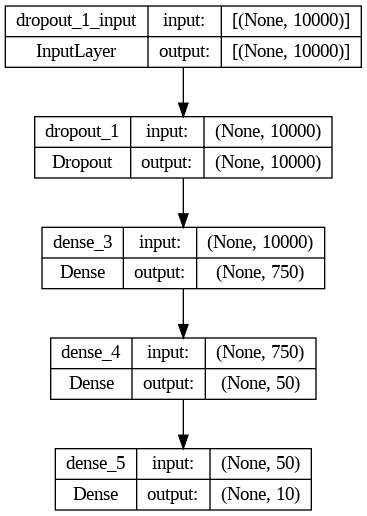

In [ ]:
# Plot model
keras.utils.plot_model(model, show_shapes=True)

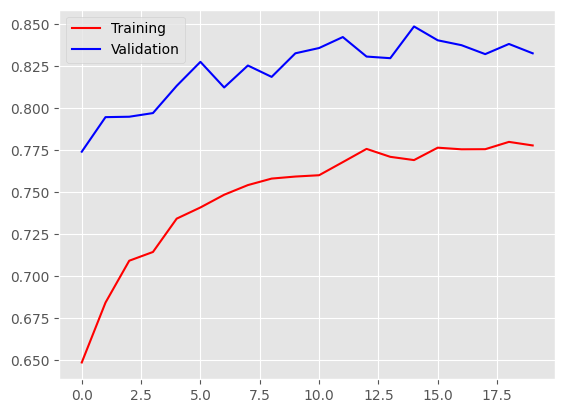

In [ ]:
# Visualize training and validation performance
plt.style.use('ggplot')

plt.plot(history.history['categorical_accuracy'],c="r")
plt.plot(history.history['val_categorical_accuracy'],c="b")
plt.legend(['Training','Validation'])
plt.show()

The Dense model ends training with a validation categorical accuracy of `0.8327`. This means that roughly `83`% of the time, the model predicts the correct one-hot encoded label for a document in the validation set.  This is considerably higher than a random guess, which in this case would have categorical accuracy equal to `0.10`, or `10`% probability. This model does not overfit, and validation categorical accuracy remains higher than training categorical accuracy during all epochs.  This may indicate that the model disproportionately predicts one label, such as "python", the most common label, since this would generally be correct.  This effect may also be attributable to our use of regularization and dropout, although these should not impact our training predictions.  We will attempt to prevent this in future models by experimenting with different data preprocessing techniques.

#### 3.1.5. Model Evaluation

In [ ]:
model = keras.models.load_model("DenseNet.keras")
test_perf = model.evaluate(test_data, test_labels)
print(f'Accuracy in the test set is {test_perf[1]*100:.2f}%.')

162/162 [==============================] - 1s 3ms/step - loss: 0.8350 - categorical_accuracy: 0.8466
Accuracy in the test set is 84.66%.


When applied to the test set, the dense model performs roughly the same in terms of categorical accuracy at `0.8350`, or `85.30`%.

### 3.2. Convolutional Neural Network

#### 3.2.1. Cleaning Labels for CNN

For our Convolutional Neural Network (CNN), we will use a new data pre-processing method using a `TextVectorization` layer from Keras to generate integer encodings of each word in our vocabulary.  Since this is a more computationally intense process, we will limit our sample to `5,000` records with no more than `2,000` tokens in the vocabulary.  We then filter for only those records with one of the `10` most popular tags, resulting in `2,625` documents.

In [ ]:
df = data.sample(5000, random_state=42)
df = df.reset_index(drop=True)
len(df)

5000

In [ ]:
# Find the most popular tag for each record, relative to the whole data set
def most_common_tag(tags, tag_counts):
    tag_list = tags.split('|')
    tag_freqs = [(tag, tag_counts[tag]) for tag in tag_list]
    most_common = max(tag_freqs, key=lambda x: x[1])
    return most_common[0]

# Extract individual tags
all_tags = []
for tags in df['tags']:
    tag_list = tags.split('|')
    all_tags.extend(tag_list)

# Count the occurrences of each tag
tag_counts = Counter(all_tags)

# Find the most frequent tag for each row
df['most_common_tag'] = df['tags'].apply(lambda tags: most_common_tag(tags, 
                                                                      tag_counts))

print(df[['tags', 'most_common_tag']])

                                                   tags most_common_tag
0               python|loops|web-scraping|beautifulsoup          python
1                               laravel|terminal|routes         laravel
2                                             mysql|sql             sql
3               javascript|class|constructor|apply|call      javascript
4                                        prism|prismlib           prism
...                                                 ...             ...
4995                                            angular         angular
4996                       r|ggplot2|plot|legend|raster               r
4997  python|function|class|recursion|binary-search-...          python
4998                               c#|unity3d|inventory              c#
4999                                 javascript|astrojs      javascript

[5000 rows x 2 columns]


In [ ]:
# Count records for each most_common_tag
df['most_common_tag'].value_counts().head(10)

python        822
javascript    532
java          234
c#            215
android       155
reactjs       153
flutter       143
r             136
c++           118
php           117
Name: most_common_tag, dtype: int64

In [ ]:
top10 = list(df['most_common_tag'].value_counts().head(10).index.values)
df_top10 = df[df['most_common_tag'].isin(top10)]
df_top10 = df_top10.reset_index(drop=True)
df_top10.count()

title              2625
body               2625
tags               2625
most_common_tag    2625
dtype: int64

In [ ]:
labels = df_top10["most_common_tag"]

Again, we one-hot encode the labels for use with `categorical_accuracy` as our loss function.

In [ ]:
# Convert labels to integer values
encoder = LabelEncoder()
encoded_labels = encoder.fit_transform(labels)
labels_onehot = keras.utils.to_categorical(encoded_labels)
print(labels_onehot)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### 3.2.2. Cleaning Text for CNN

We repeat many of the same steps from above for CNN and RNN, except here we rely on the TextVectorization layer to do some of the work for us, like placing all tokens in lower case and limiting vocabulary to `2,000` terms.  This is the first time we limit document length to the first `1,000` tokens, and this is again to limit the computational power required to run each model.  Most documents in the data set were longer than `1,000` tokens, but not all of these were legitimate.  Some were artifacts from URLs and other embedded text from the original Stack Overflow posts.

In [ ]:
# Load spaCy's English language model
nlp = spacy.load('en_core_web_sm')

# Clean text
def clean_text(text):
    text = re.sub(r'[^\w ]', ' ', text)  # Remove HTML tags
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    text = text.strip()  # Remove leading and trailing spaces
    return text

# Remove stopwords
def remove_stopwords(text):
    doc = nlp(text)
    tokens = [token.text for token in doc if not token.is_stop][:1000] # Cuts strings at 1000 tokens
    return ' '.join(tokens)

# Combine the title and body
df_top10['text'] = df_top10['title'] + ' ' + df_top10['body']

# Apply the clean_text and remove_stopwords functions
df_top10['text'] = df_top10['text'].apply(clean_text)
df_top10['text'] = df_top10['text'].apply(remove_stopwords)

# Store in array
text = df_top10['text'].to_numpy()

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    max_tokens=2000, # We will use the 2000 most frequent terms; doing this automatically pads the sequences.
    output_mode="int")

text_vectorization.adapt(text)

This layer will assign an integer value to each of the most frequent `2,000` words. The vector representation of the cleaned text is visible as output to the next block of code. Here, `1` indicates an unknown token and `0` indicates a blank space appended as padding so that all sequences are the same length.  This is important for implementing a CNN since convolutional operations rely on padding to preserve meaningful data in the original dimensions of the subject tensor. Next, we'll one-hot encode these vector representations of our vocabulary and train the CNN.

In [ ]:
clean_text = text[0]
print(f'CLEAN TEXT: \n{clean_text}\n')
text_len = len(clean_text.split(' '))
print(f'DETAILS: \nThe post contains roughly {text_len} words (based on white spaces).')
vectorized_post = text_vectorization(text)
print(f'It\'s vectorized (and padded) form contains {vectorized_post.shape[1]} tokens.\n')
print(f'VECTOR REPRESENTATION:\n')
vectorized_post[0]

CLEAN TEXT: 
iterate list URL save CSV pre code import requests bs4 import BeautifulSoup headers User Agent Mozilla 5 0 Macintosh Intel Mac OS X 10_15_7 AppleWebKit 537 36 KHTML like Gecko Chrome 103 0 0 0 Safari 537 36 Accept Language en en q 0 5 URL quot https www amazon com TRESemm C3 A9 Botanique Shampoo Nourish Replenish dp B0199WNJE8 ref sxin_14_pa_sp_search_thematic_sspa content d amzn1 sym a15c61b7 4b93 404d bb70 88600dfb718d 3Aamzn1 sym a15c61b7 4b93 404d bb70 88600dfb718d amp crid 2HG5WSUDCJBMZ amp cv_ct_cx hair 2Btresemme amp keywords hair 2Btresemme amp pd_rd_i B0199WNJE8 amp pd_rd_r 28d72361 7f35 4b1a be43 98e7103da70c amp pd_rd_w 6UL4P amp pd_rd_wg JtUqB amp pf_rd_p a15c61b7 4b93 404d bb70 88600dfb718d amp pf_rd_r DFPZNAG391M5JS55R6HP amp qid 1660432925 amp sprefix hair 2Btresemme 2Caps 2C116 amp sr 1 3 a73d1c8c 2fd2 4f19 aa41 2df022bcb241 spons amp smid A3DEFW12560V8 M amp spLa ZW5jcnlwdGVkUXVhbGlmaWVyPUExQlM3VFpGRVM5Tk8wJmVuY3J5cHRlZElkPUEwNjE5MjQwM01JV0FNN1pOMlRHSSZlbm

<tf.Tensor: shape=(1000,), dtype=int64, numpy=
array([   1,   50,  148,  341,  303,    7,    4,   22,  611,    1,   22,
          1,  437,   62, 1319,    1,   34,    8,    1,    1,    1,  360,
         43,    1,    1,    1,  778,    1,   45,    1,  520,    1,    8,
          8,    8,    1,    1,  778,  991,  865,  615,  615,  515,    8,
         34,  148,    2,   16,  315, 1294,   14,    1,    1,    1,    1,
          1,    1,    1,  684,    1,  664,    1,  152,   17,    1,    1,
          1,    1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
          1,   44,    1,    1,   44,    1,    1,    1,   44,    1,    1,
          1,   44,    1,    1,   44,    1,    1,    1,    1,    1,    1,
         44,    1,    1,   44,    1,    1,   44,    1,    1,    1,    1,
          1,    1,   44,    1,    1,   44,    1,    1,   44,    1,    1,
          1,    1,    1,   44,    1,    9,   19,    1,    1,    1,    1,
          1,    1,   44,    1,    1,   33,   44,    1,    1,   44,   94,
    

In [ ]:
one_hot_post = tf.one_hot(vectorized_post, depth=2000) 
print(one_hot_post.shape)

(2625, 1000, 2000)


#### 3.2.3. Train-Test Split

Since we scaled down our sample to only `2,625` documents we can separate training and test sets using a simple index.  Here, the first `2,100` records are used for training and validation, while the remaining `525` are used as a test set.

In [ ]:
data_train = text[:2100]
labels_train = labels_onehot[:2100]
data_test = text[2100:]
labels_test = labels_onehot[2100:]

#### 3.2.4. Model Training

For this model, we are going to implement class weights to balance the disproportionate class distribution.  Scikit-Learn has a `class_weight` package that accomplishes this by learning the encoded lables from above.

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(encoded_labels), y=encoded_labels)
class_weights = dict(enumerate(class_weights))

The CNN we implement incorporates a SeparableConv1D Layer which enables us to combine the outputs of the first and second convolutional layers by allowing them to "skip" layers.  This helps preserve gradients within the network, combatting vanishing gradient, and ultimately providing us with a more accurate label prediction.  Without this effect, a simple Conv1D Layer received a categorical accuracy score around `0.70`.  

Our GlobalAveragePooling1D Layer compresses the feature maps into a single vector which is then passed to the output layer to make a final prediction.  Pooling layers are widely used in CNNs to downsample feature maps of higher dimensional tensors.

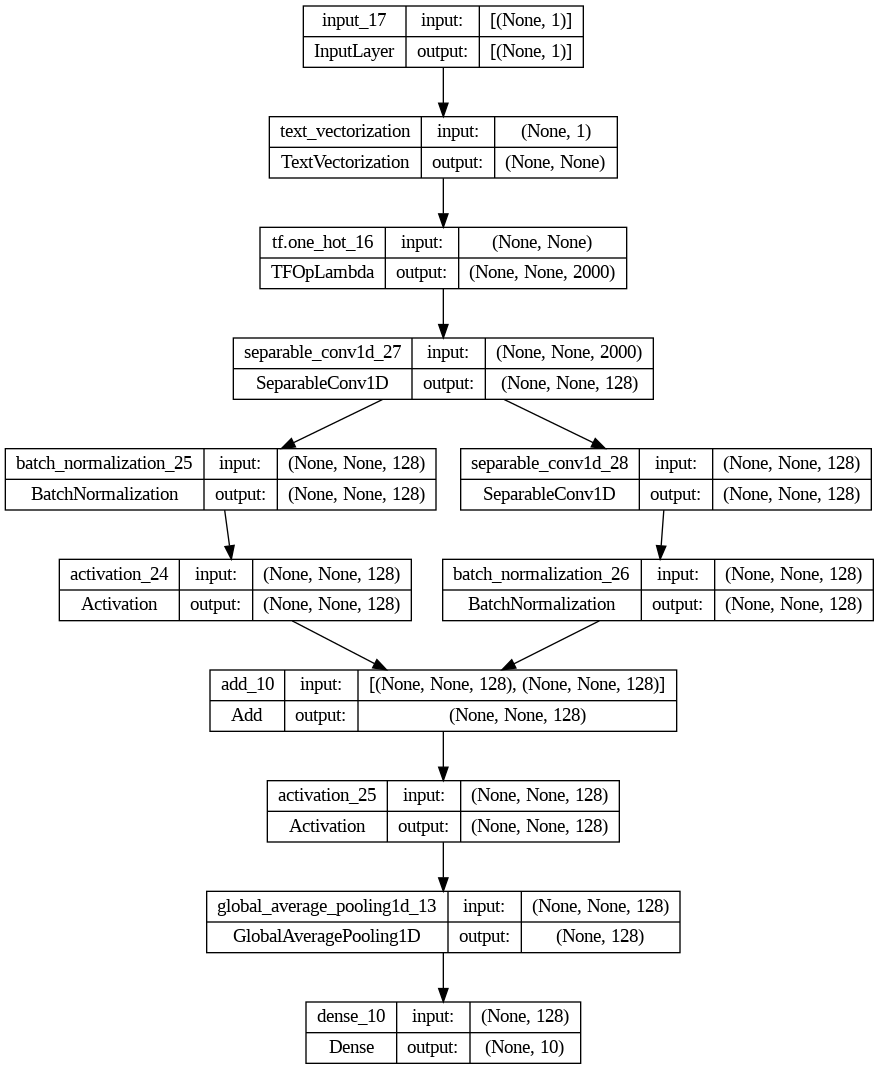

In [ ]:
def build_model():
    inputs = keras.layers.Input(shape=(1), dtype="string")
    processing = text_vectorization(inputs)
    one_hot = tf.one_hot(processing, depth=2000) 

    conv1 = layers.SeparableConv1D(128, kernel_size=10, padding='same')(one_hot)
    batch1 = layers.BatchNormalization()(conv1)
    act1 = layers.Activation('relu')(batch1)

    conv2 = layers.SeparableConv1D(128, kernel_size=10, padding='same')(conv1)
    batch2 = layers.BatchNormalization()(conv2)
    skip1 = layers.Add()([act1, batch2])
    act2 = layers.Activation('relu')(skip1)

    # Define global pooling layer
    pool = layers.GlobalAveragePooling1D()(act2)

    outputs = layers.Dense(units=10, activation='softmax')(pool)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['categorical_accuracy'])
    return model

model = build_model()

keras.utils.plot_model(model, show_shapes=True)

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="CNN.tf",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(data_train, labels_train, validation_split=0.2, epochs=20, 
                    batch_size=16, callbacks=callbacks, class_weight=class_weights)

Epoch 1/20
105/105 [==============================] - 6s 29ms/step - loss: 2.2453 - categorical_accuracy: 0.2155 - val_loss: 2.2598 - val_categorical_accuracy: 0.4000
Epoch 2/20
105/105 [==============================] - 3s 26ms/step - loss: 1.4457 - categorical_accuracy: 0.6750 - val_loss: 2.0176 - val_categorical_accuracy: 0.3167
Epoch 3/20
105/105 [==============================] - 3s 32ms/step - loss: 0.8874 - categorical_accuracy: 0.8238 - val_loss: 1.5310 - val_categorical_accuracy: 0.7976
Epoch 4/20
105/105 [==============================] - 3s 26ms/step - loss: 0.5821 - categorical_accuracy: 0.8798 - val_loss: 1.2134 - val_categorical_accuracy: 0.7476
Epoch 5/20
105/105 [==============================] - 3s 26ms/step - loss: 0.3836 - categorical_accuracy: 0.9214 - val_loss: 0.9930 - val_categorical_accuracy: 0.7738
Epoch 6/20
105/105 [==============================] - 1s 8ms/step - loss: 0.2819 - categorical_accuracy: 0.9571 - val_loss: 1.1239 - val_categorical_accuracy: 0.7000

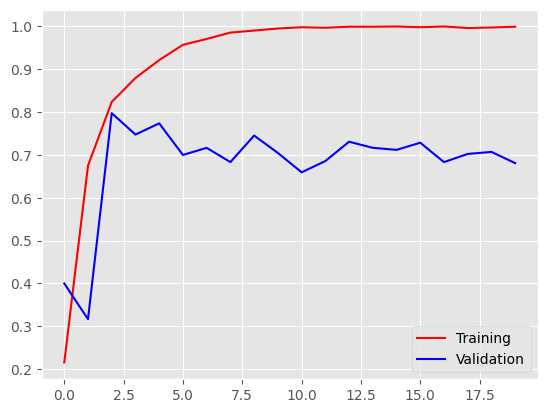

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['categorical_accuracy'],c="r")
plt.plot(history.history['val_categorical_accuracy'],c="b")
plt.legend(['Training','Validation'])
plt.show()

While our validation performance appears to vary, the model structure enables better performance than a Conv1D layer alone.

#### 3.2.3. Model Evaluation

In [ ]:
model = keras.models.load_model("CNN.tf")
test_perf = model.evaluate(data_test, labels_test)
print(f'Accuracy in the test set is {test_perf[1]*100:.2f}%.')

17/17 [==============================] - 0s 7ms/step - loss: 1.0738 - categorical_accuracy: 0.7733
Accuracy in the test set is 77.33%.


Our test performance increases around `7`% by implementing the SeparableConv1D layers into the above model.

### 3.3. Recurrent Neural Network

#### 3.3.1. Preprocessing for RNN

The data preprocessing for our RNN is highly similar to that of the CNN, except instead of one-hot encoding the vocabulary we will input strings into the RNN and generate 8-dimensional embeddings of the tokens.  Therefore we must ensure our training data is in the appropriate format.

In [ ]:
data_train[5]

'fix android emulator issue p installed android studio windows 10 trying create emulator causing issues href https stack imgur com 5qzCk png rel nofollow noreferrer img src https stack imgur com 5qzCk png alt enter image description p p nt graphics card driver installed tried graphics Automatic Software Hardware emulator p p root cause resolve issue p'

#### 3.3.1. Model Training

We implement an RNN that learns 8-dimension embeddings of our vocabulary forward and backward with Long Short-Term Memory (LSTM).  RNNs succeed with timeseries-related tasks like forecasting. The implementation of LSTM aided in their effectiveness over longer sequences that were previously plagued by vanishing gradient.  When used in NLP tasks, vocabulary is often capped at `10,000` tokens, so our `2,000` token vocabulary should be easily managed by this model.  However, we did limit our data set significantly in order to run the model in a timely manner.  A larger training set would undoubtedly improve predictions.

RNNs like this rely more heavily on multiple CPUs instead of leveraging the parallel processing from GPUs since their simple calculations are not easily parallelized.  Therefore, this model has a longer training timelines even with a high RAM Colab session.

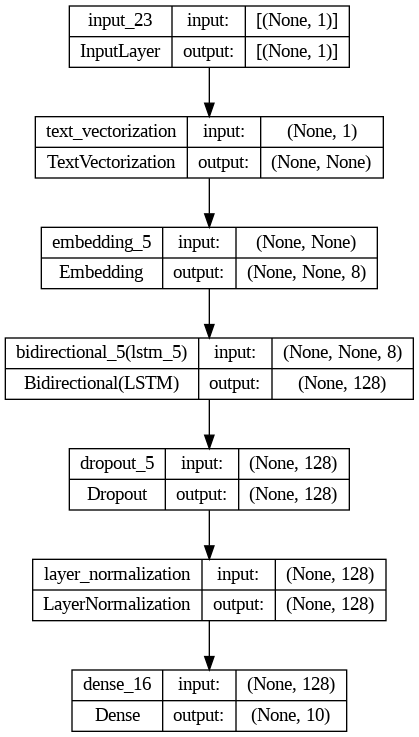

In [ ]:
def build_model_embed():
    inputs = keras.layers.Input(shape=(1), dtype="string") # We take our strings as input 
    processing = text_vectorization(inputs)
    embedding = keras.layers.Embedding(input_dim=2000,output_dim=8, mask_zero=True)(processing)
    
    # Bidirectional LSTM to read embeddings
    x = keras.layers.Bidirectional(keras.layers.LSTM(64))(embedding)
    x = keras.layers.Dropout(0.5)(x)
    x = layers.LayerNormalization()(x)
    outputs = keras.layers.Dense(10, activation="softmax")(x)

    model = keras.Model(inputs,outputs)
    model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['categorical_accuracy'])
    return model

model_embed = build_model_embed()

keras.utils.plot_model(model_embed, show_shapes=True)

BatchNormalization layers are not typically used with RNNs, as they attempt to normalize single values as opposed to applying the same features across all batch examples (Huber). For this reason, we implement LayerNormalization in our RNN, since it was purpose-built for RNNs.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="RNN_embed.tf",
        save_best_only=True,
        monitor="val_loss")
]

history = model_embed.fit(data_train, labels_train, validation_split=0.2, 
                          epochs=20, batch_size=16, callbacks=callbacks, 
                          class_weight=class_weights)

Epoch 1/20
105/105 [==============================] - 49s 392ms/step - loss: 2.3126 - categorical_accuracy: 0.1405 - val_loss: 2.2466 - val_categorical_accuracy: 0.1786
Epoch 2/20
105/105 [==============================] - 36s 341ms/step - loss: 1.8916 - categorical_accuracy: 0.3018 - val_loss: 1.7440 - val_categorical_accuracy: 0.4000
Epoch 3/20
105/105 [==============================] - 32s 309ms/step - loss: 1.3340 - categorical_accuracy: 0.4798 - val_loss: 1.5733 - val_categorical_accuracy: 0.4500
Epoch 4/20
105/105 [==============================] - 29s 282ms/step - loss: 0.9020 - categorical_accuracy: 0.6560 - val_loss: 1.3779 - val_categorical_accuracy: 0.5190
Epoch 5/20
105/105 [==============================] - 32s 301ms/step - loss: 0.6305 - categorical_accuracy: 0.7560 - val_loss: 1.3677 - val_categorical_accuracy: 0.5857
Epoch 6/20
105/105 [==============================] - 7s 62ms/step - loss: 0.4632 - categorical_accuracy: 0.8238 - val_loss: 2.0886 - val_categorical_accur

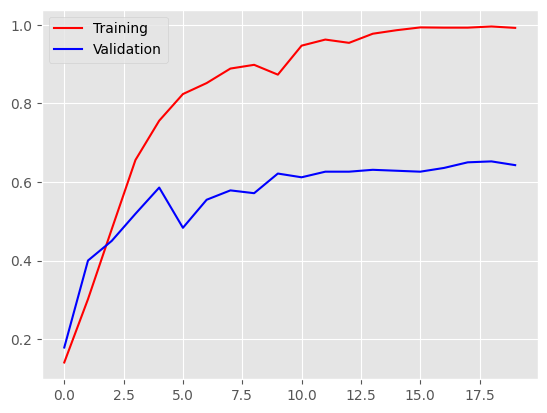

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

plt.plot(history.history['categorical_accuracy'],c="r")
plt.plot(history.history['val_categorical_accuracy'],c="b")
plt.legend(['Training','Validation'])
plt.show()

Adding a LayerNormalization layer to this RNN increased categorical accuracy in the validation set by almost `0.20`.  This demonstrates the massive effect of normalization during the training process. 

#### 3.3.2. Model Evaluation

In [ ]:
model = keras.models.load_model("RNN_embed.tf")
test_perf = model.evaluate(data_test, labels_test)
print(f'Accuracy in the test set is {test_perf[1]*100:.2f}%.')

17/17 [==============================] - 3s 26ms/step - loss: 1.3506 - categorical_accuracy: 0.5790
Accuracy in the test set is 57.90%.


Despite our rearrangements in its configuration, the RNN performs the worst of our first three models with a test categorical accuracy of `0.5790`.  This model may be limited in the amount of data we used, either in terms of vocabulary fed to the model, or the number of documents.

### 3.4. Transformer-Enabled Neural Network

Bidirectional Encoder Representaions from Transformers (BERT)

The last model we attempted is a pre trained langauge model - BERT, which was introduced in `2018` by researchers at Google. We are using the base model - 'bert-base-cased' model which has `12` layers, `768` hidden units and `110M` parameters.

#### 3.4.1. Model Precprocessing


1. Convert `tags` to numeric

2. Create a function `generate_training_data`, that processes `text` column, tokenizes the text using the provided `BERT tokenizer`, and stores the resulting `token IDs` and `attention masks` in the pre-allocated arrays ids and masks, respectively.

3. One-hot encode the `tags` to create a binary matrix representation of the labels. `Inline code`

This ensures our data is ready to be split into train/validation in batches.

##### 3.4.1.1. **Step 1:** Convert `tags` to numeric

In [ ]:
# Get the distinct tags
distinct_tags = df_top10['most_common_tag'].unique()

# Create a dictionary to map tags to integers
tag_to_numeric = {tag: i for i, tag in enumerate(distinct_tags)}

In [ ]:
df_top10['numeric_tag'] = df_top10['most_common_tag'].map(tag_to_numeric)

In [ ]:
# tag to numeric key mapping
print("Tag to Numeric Key:")
for tag, numeric in tag_to_numeric.items():
    print(f"{tag}: {numeric}")

Tag to Numeric Key:
python: 0
javascript: 1
c++: 2
php: 3
android: 4
r: 5
c#: 6
java: 7
flutter: 8
reactjs: 9


##### 3.4.1.2. **Step 2:** Function to tokenize texts

Create a function `generate_training_data`, that processes `text` column, tokenizes the text using the provided `BERT tokenizer`, and stores the resulting `token IDs` and `attention masks` in the pre-allocated arrays ids and masks, respectively. `token ID's` contain our unique tokens for each word, whereas `attention masks` are filled with 1's (indicating the token is present) and 0's (indicating padding)

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 85.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00


In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [ ]:
X_input_ids = np.zeros((len(df_top10), 256))
X_attn_masks = np.zeros((len(df_top10), 256))

In [ ]:
X_input_ids.shape

(25779, 256)

In [ ]:
def generate_training_data(df, ids, masks, tokenizer):
    for i, text in tqdm(enumerate(df['text'])):
        tokenized_text = tokenizer.encode_plus(
            text,
            max_length=256, 
            truncation=True, 
            padding='max_length', 
            add_special_tokens=True,
            return_tensors='tf'
        )
        ids[i, :] = tokenized_text.input_ids
        masks[i, :] = tokenized_text.attention_mask
    return ids, masks

In [ ]:
from tqdm.auto import tqdm
X_input_ids, X_attn_masks = generate_training_data(df_top10, X_input_ids, X_attn_masks, tokenizer)

0it [00:00, ?it/s]

##### 3.4.1.3. **Step 3:** One-hot encode the `tags`

Create a binary matrix representation of the labels using one hot encoding

In [ ]:
labels = np.zeros((len(df_top10),10))
labels.shape

(25779, 10)

In [ ]:
labels[np.arange(len(df_top10)), df_top10['numeric_tag'].values] = 1 # one-hot encoded target tensor

In [ ]:
labels

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [ ]:
import tensorflow as tf
# creating a data pipeline using tensorflow dataset utility, creates batches of data for easy loading...
dataset = tf.data.Dataset.from_tensor_slices((X_input_ids, X_attn_masks, labels))
dataset.take(1) # one sample data

<_TakeDataset element_spec=(TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(256,), dtype=tf.float64, name=None), TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [ ]:
def SentimentDatasetMapFunction(input_ids, attn_masks, labels):
    return {
        'input_ids': input_ids,
        'attention_mask': attn_masks
    }, labels

#### 3.4.2. Split data into training/validation

In [ ]:
dataset = dataset.map(SentimentDatasetMapFunction) # converting to required format for tensorflow dataset 

In [ ]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(256,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(256,), dtype=tf.float64, name=None)}, TensorSpec(shape=(10,), dtype=tf.float64, name=None))>

In [ ]:
dataset = dataset.shuffle(25779).batch(16, drop_remainder=True) # batch size, drop any left out tensor

In [ ]:
p = 0.8
train_size = int((len(df_top10)//16)*p) # for each 16 batch of data we will have len(df)//16 samples, take 80% of that for train.

In [ ]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

#### 3.4.3. Model Training

Here's a brief overview of the model:

- `Input layers:` input_ids and attention_mask are the input layers that receive tokenized text and attention masks, respectively, with a sequence length of 256.
BERT layer: The bert layer uses the TFBertMainLayer, which is a pre-trained BERT model. It takes input_ids and attention_mask as inputs and outputs a tuple containing pooled output and hidden states.
- `Intermediate layer:` A dense (fully connected) layer with 512 units, which takes the pooled output from the BERT layer as input. It serves as an intermediate layer for further processing and feature extraction.
- `Output layer:` A dense layer with 10 units, which corresponds to the number of output classes. It takes the output from the intermediate layer and produces the final classification scores.

In [ ]:
from transformers import TFBertModel
model = TFBertModel.from_pretrained('bert-base-cased') # bert base model with pretrained weights

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
# defining 2 input layers for input_ids and attn_masks
input_ids = tf.keras.layers.Input(shape=(256,), name='input_ids', dtype='int32')
attn_masks = tf.keras.layers.Input(shape=(256,), name='attention_mask', dtype='int32')

bert_embds = model.bert(input_ids, attention_mask=attn_masks)[1] # 0 -> activation layer (3D), 1 -> pooled output layer (2D)
intermediate_layer = tf.keras.layers.Dense(512, activation='relu', name='intermediate_layer')(bert_embds)
output_layer = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(intermediate_layer) # softmax -> calcs probs of classes

sentiment_model = tf.keras.Model(inputs=[input_ids, attn_masks], outputs=output_layer)
sentiment_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [ ]:
optim = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5, decay=1e-6)
loss_func = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

In [ ]:
sentiment_model.compile(optimizer=optim, loss=loss_func, metrics=[acc])

In [ ]:
hist = sentiment_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10
)

Epoch 1/10
1288/1288 [==============================] - 140s 100ms/step - loss: 1.1286 - accuracy: 0.6228 - val_loss: 0.5061 - val_accuracy: 0.8257
Epoch 2/10
1288/1288 [==============================] - 126s 98ms/step - loss: 0.4906 - accuracy: 0.8307 - val_loss: 0.3756 - val_accuracy: 0.8611
Epoch 3/10
1288/1288 [==============================] - 127s 98ms/step - loss: 0.3758 - accuracy: 0.8617 - val_loss: 0.2528 - val_accuracy: 0.9036
Epoch 4/10
1288/1288 [==============================] - 127s 98ms/step - loss: 0.3098 - accuracy: 0.8843 - val_loss: 0.2184 - val_accuracy: 0.9133
Epoch 5/10
1288/1288 [==============================] - 126s 98ms/step - loss: 0.2521 - accuracy: 0.9026 - val_loss: 0.1750 - val_accuracy: 0.9325
Epoch 6/10
1288/1288 [==============================] - 126s 98ms/step - loss: 0.2128 - accuracy: 0.9144 - val_loss: 0.1399 - val_accuracy: 0.9423
Epoch 7/10
1288/1288 [==============================] - 126s 98ms/step - loss: 0.1845 - accuracy: 0.9262 - val_loss: 

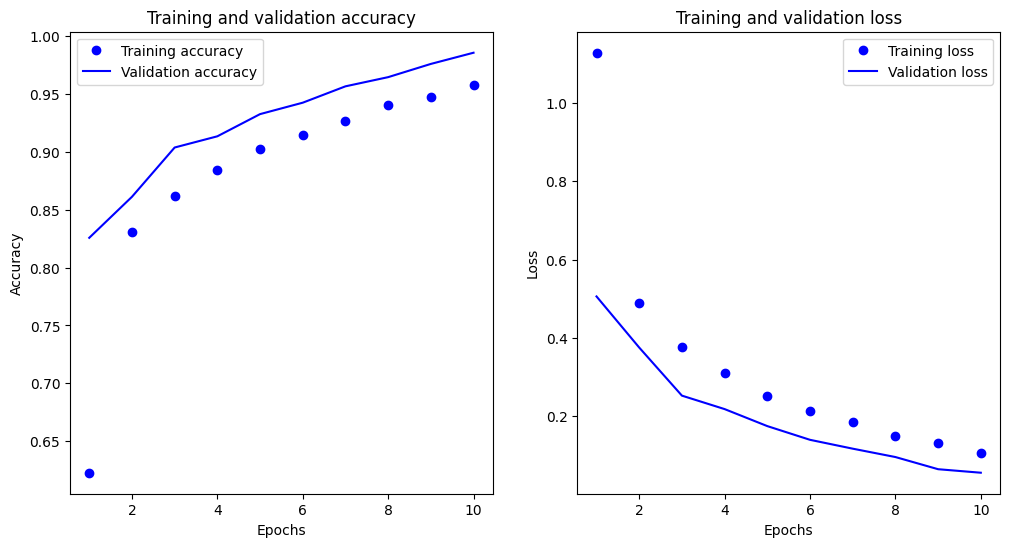

In [ ]:
import matplotlib.pyplot as plt

# Extract the training and validation accuracy and loss from the history object
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']

# Define the number of epochs
epochs = range(1, len(train_acc) + 1)

# Plot the training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.show()


In [ ]:
sentiment_model.save('sentiment_model')

In the later section (4.2), we will take a look at how BERT performs on additional unseen data (examples of stackoverflow questions) 

## 4. Conclusions

### 4.1. Best Model

The BERT-based model outperforms all other models in this notebook with a more limited amount of data.  This is a testament to pretrained models' ability to enhance projects where limited data sets are available for training.  With a validation categorical accuracy of `0.9855`, we prefer to use BERT for our sentiment classification task.  

This of course comes with the additional requirement for advanced computational resources.  In order to run BERT effectively, even on a limited vocabulary, we had to purchase access to Premium GPUs on Colab.  Without these higher memory GPUs, training the BERT-based model would have taken over two hours.  All in all, we spent $60 for access to GPUs, which was well worth the time saved, but this would be a major consideration for a business choosing to use a BERT-based model to make predictions for a chatbot.  The return on investment from implementing this model would likely inform a company's decision.

### 4.2. BERT Prediction on Unseen Data
Let's examine how `BERT` performs on unseen data by testing its predictions on three example questions from Stack Overflow. These questions are tagged with `JavaScript`, `Python`, and `PHP`. Given that BERT achieved 99% accuracy on our validation data, we anticipate that it will accurately classify these new questions.

In [ ]:
sentiment_model = tf.keras.models.load_model('sentiment_model')

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token.input_ids, tf.float64),
        'attention_mask': tf.cast(token.attention_mask, tf.float64)
    }

def make_prediction(model, processed_data, classes=['Python', 'javascript', 'c++', 'php', 'android','r','c#','java','flutter','reactjs']):
    probs = model.predict(processed_data)[0]
    return classes[np.argmax(probs)]

#### 4.2.1 Example 1: [Javascript tag example](https://stackoverflow.com/questions/76150062/overriding-javascript-iframe-styling-with-css/)

The user is developing a Wordpress website and has embedded a Square booking flow using a script tag. They want to change the default blue color of the booking flow elements to a red color that matches the client's branding. Although they can change the color using the browser's inspect element feature, applying the same CSS selectors in their own stylesheet doesn't work. They're looking for a way to override the styling of the script/iframe with their own CSS and need guidance on how to do it.

In [ ]:
input_text = input('Enter coding question here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(sentiment_model, processed_data=processed_data)
print(f"Predicted Sentiment: {result}")

Enter coding question here: Overriding Javascript/iFrame styling with CSS. I am developing a Wordpress website for a client who uses Square booking for their business. Square allows users to embed the booking flow onto their own websites, which is what I am doing. It gave me a script tag to use and I have implemented it onto the website. The issue, however, is that the styling of the booking flow uses a blue color while I am trying to change the blue elements to the red color that this business uses. I have been able to change the blue to red using inspect element, however when I then use those CSS selectors that worked in the inspect element on my own stylesheet is does not reflect any change. I think what I am looking to do, if I'm not mistaken, is to override the styling of the script/iframe with my own CSS. Is this possible? And if so, how would I go about it?  For reference, the website I am building, and the particular page that has the embedded script is staged here: https://pgh

#### 4.2.2 Example 2: [Python tag example](https://stackoverflow.com/questions/76149904/i-cant-install-any-package-using-pip-or-pipenv/)

The user is unable to install packages like Flask, psycopg2, and Flask-SQLAlchemy using pip or pipenv due to an OSError with a Permission Denied error message in Python.

In [ ]:
input_text = input('Enter coding question here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(sentiment_model, processed_data=processed_data)
print(f"Predicted Sentiment: {result}")

Enter coding question here: I can't install any package using pip or pipenv. I want to install many packages for my project like flask or psycopg2 or flask-sqlachermy but i can't. When i use the pip i receive this error message:  **ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'C:\\Users\\ASUS\\AppData\\Local\\Programs\\Python\\Python310\\Lib\\site-packages\\markupsafe\\_speedups.c' Consider using the `--user` option or check the permissions.** When i use the pipenv i receive this error message: **ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'C:\\Users\\ASUS\\.virtualenvs\\ASUS-mVsQ382S\\Lib\\site-packages\\markupsafe\\_speedups.c' Check the permissions.** [enter image description here](https://i.stack.imgur.com/lc1NB.png)  I tried to install again the markupsafe package because i thint that it is the source of the problem but it's not working
1/1 [==============================] - 0s 62ms/step
Predicted Sentime

#### 4.2.3 Example 3: [PHP tag example](https://stackoverflow.com/questions/60174/how-can-i-prevent-sql-injection-in-php) 

The user is asking for methods to prevent SQL injection in PHP. They provide an example where user input is directly inserted into an SQL query without modification, making the application vulnerable to SQL injection. They are seeking solutions to avoid this security issue.

In [ ]:
input_text = input('Enter coding question here: ')
processed_data = prepare_data(input_text, tokenizer)
result = make_prediction(sentiment_model, processed_data=processed_data)
print(f"Predicted Sentiment: {result}")

Enter coding question here: How can I prevent SQL injection in PHP? If user input is inserted without modification into an SQL query, then the application becomes vulnerable to SQL injection, like in the following example:  $unsafe_variable = $_POST['user_input'];   mysql_query("INSERT INTO `table` (`column`) VALUES ('$unsafe_variable')"); That's because the user can input something like value'); DROP TABLE table;--, and the query becomes:  INSERT INTO `table` (`column`) VALUES('value'); DROP TABLE table;--') What can be done to prevent this from happening?
1/1 [==============================] - 0s 57ms/step
Predicted Sentiment: php


As is evident, BERT was able to correctly classify all three questions.

### 4.3. Challenges and Future Scope

#### 4.3.1. Use Pre-Trained Transformers When Feasible
The use of BERT in our prediction problem, while initially challenging, proved to yield our most accurate model.  This is because pre-trained transformers already have learned weights associated with large vocabularies, so one needs only to attach a classifier to generate a model.  Originally, we thought the somewhat specialized vocabulary of Stack Overflow posts would prevent BERT from being a useful solution; however the opposite proved to be true.  While there are certainly occasions where implementing a pre-trained transformer is either unfeasible, or would be a matter of overkill, they generally offer high accuracy where a large training dataset is not available.

#### 4.3.2. Garbage In, Garbage Out
This is a topic discussed in the second edition of Chollet's _Deep Learning with Python_, and it is one that begs reiterating (2021).  For each of the models we attempted, the most crucial step to improve performance was the tailoring of the data before entering a model.  For example, our removal of stop words from spaCy's English language model improved an initial feed-forward network more than numerous configurations layers.  Taking the time to clean and shape input data into the correct tensor format will pay dividends in model performance.

#### 4.3.3. Feature Selection
With more time, another avenue to explore with this project is the additional features in our original dataset that we did not explore.  Since we only used the text and tags from each Stack Overflow post, we lost potential value from the other features like `view_count`, `answer_count`, and information about date and time.  One or more of these additional features may have proven valuable in predicting a post's intention.

#### 4.3.4. Predicting Top N Labels
Finally, another direction we could have taken this project is predicting multiple labels, or intentions, of each post.  Due to the amount of time and resources we had available, picking the top label was most feasible, but this project could be adapted to predict any number of associated labels with varying degrees of accuracy.

#### 4.3.5. Closing Thoughts
While not all-encompassing, this project afforded us the opportunity to test various lessons learned in the course and in _Deep Learning with Python_ through the context of our own problem set (2021).  The project allowed us to review concepts from early in the semester, and apply new, more challenging methods than what we saw in class.  It was time well-spent toward our future careers, and it demonstrates a higher level of knowledge than we had achieved at the beginning of the course. To sum it up, this project has not only deepened our understanding of neural networks and intent detection but also paved the way for further developing a chatbot. By utilizing a novel dataset and focusing on the chatbot context, we created a solid foundation for ongoing exploration in the realm of deep learning and artificial intelligence.

## 5. References

> 1. Google Cloud (2023). Stack Overflow - Stack Exchange. _Google Cloud Marketplace_. https://console.cloud.google.com/marketplace/product/stack-exchange/stack-overflow/

> 2. Chollet, Francois (2021). Deep Learning with Python (Second Edition). _Manning Publications Co._

> 3. Huber, Johann (2020, Nov 6). Batch normalization in 3 levels of understanding. _Medium_. https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338#d000